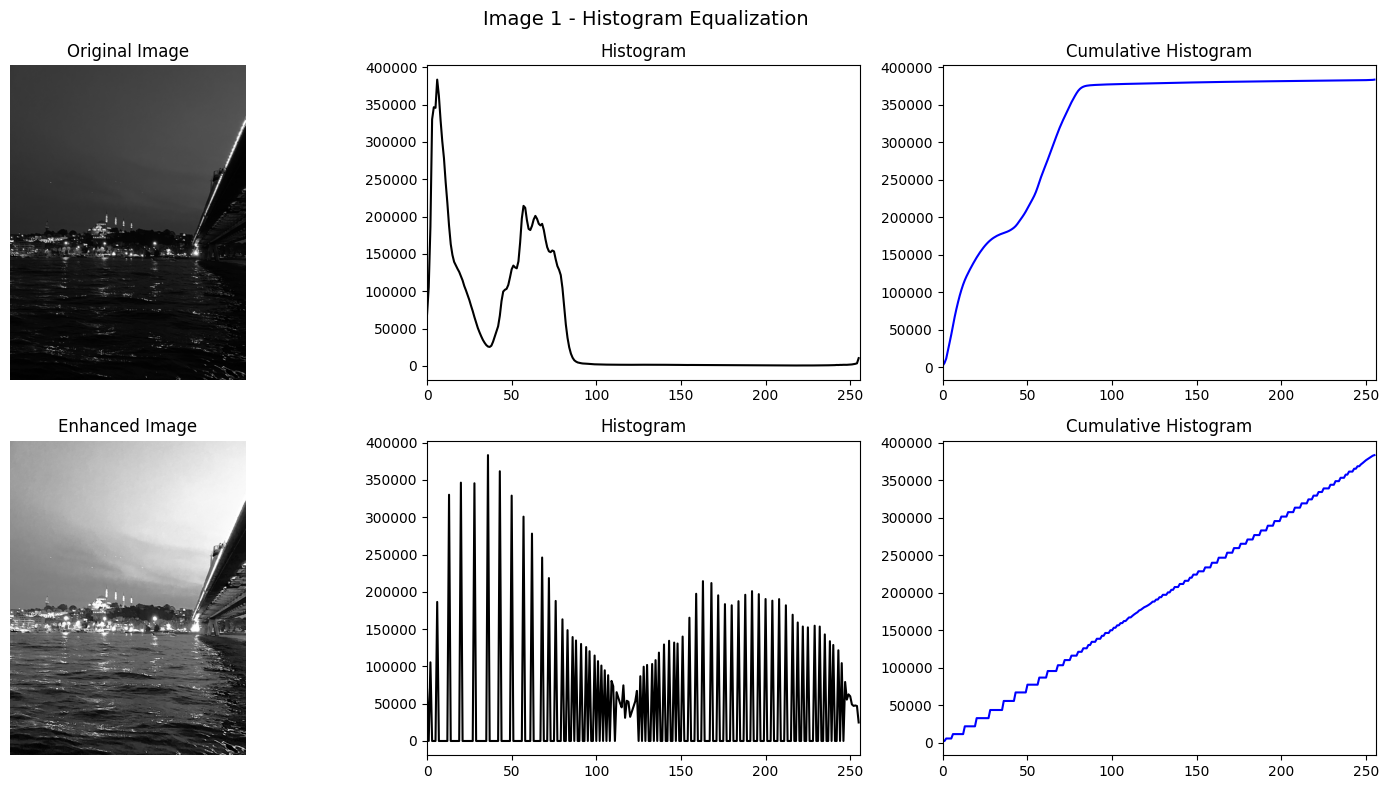

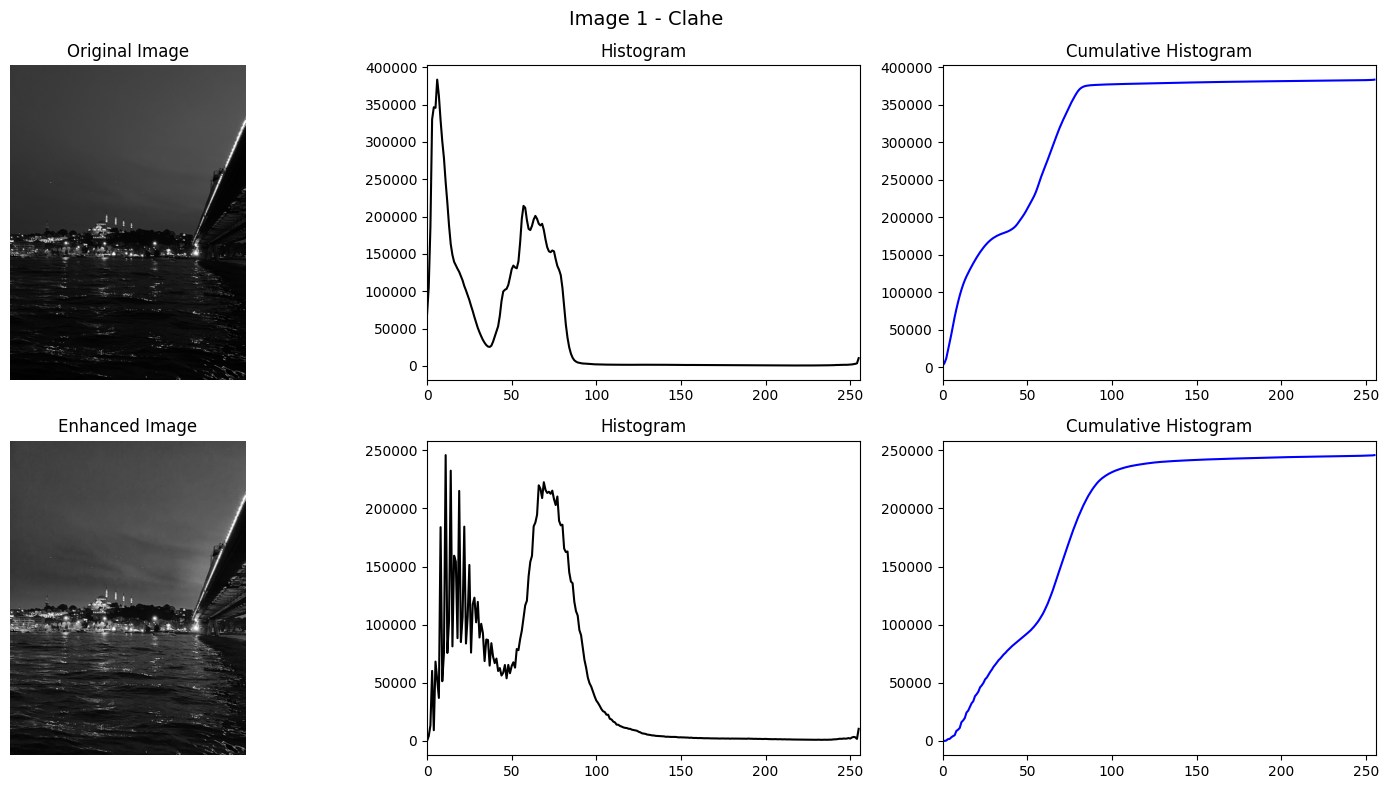

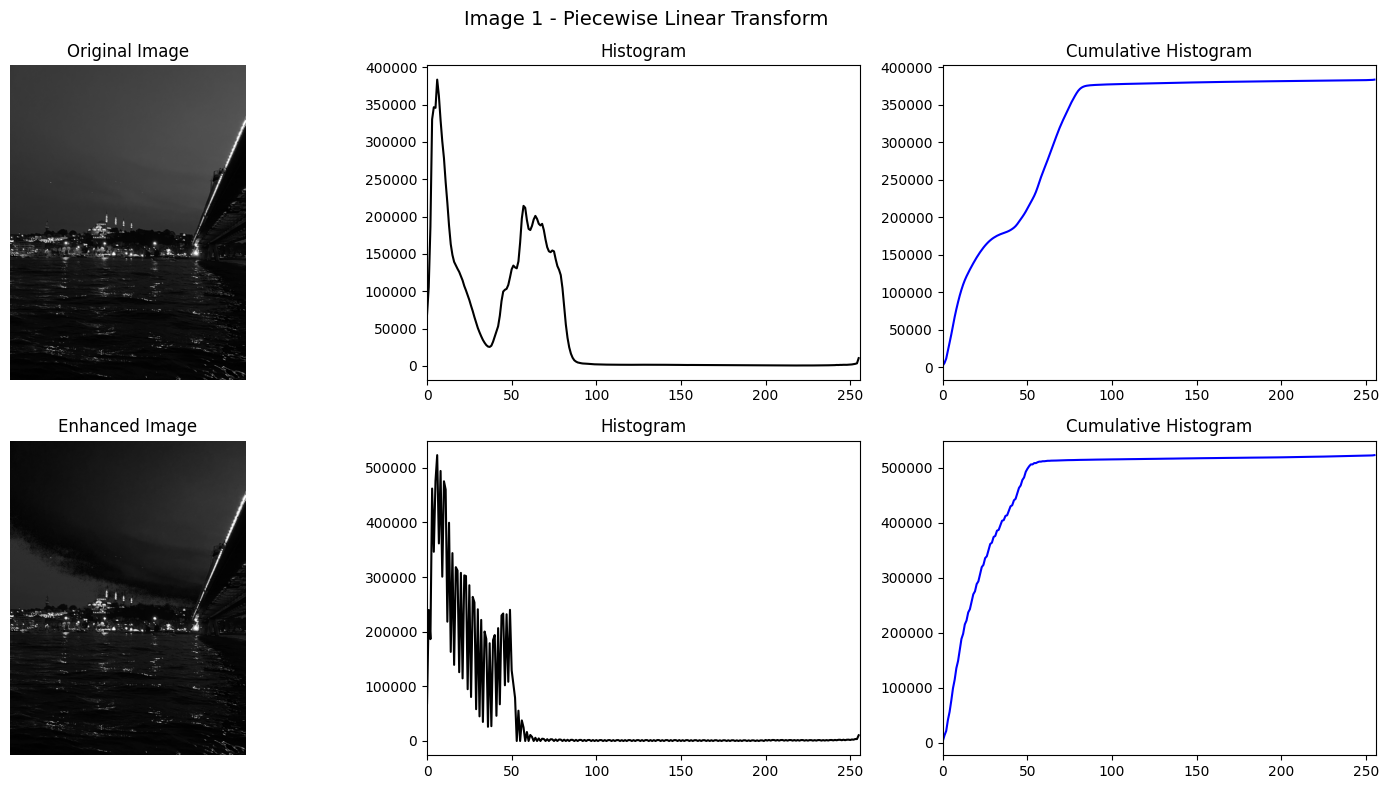

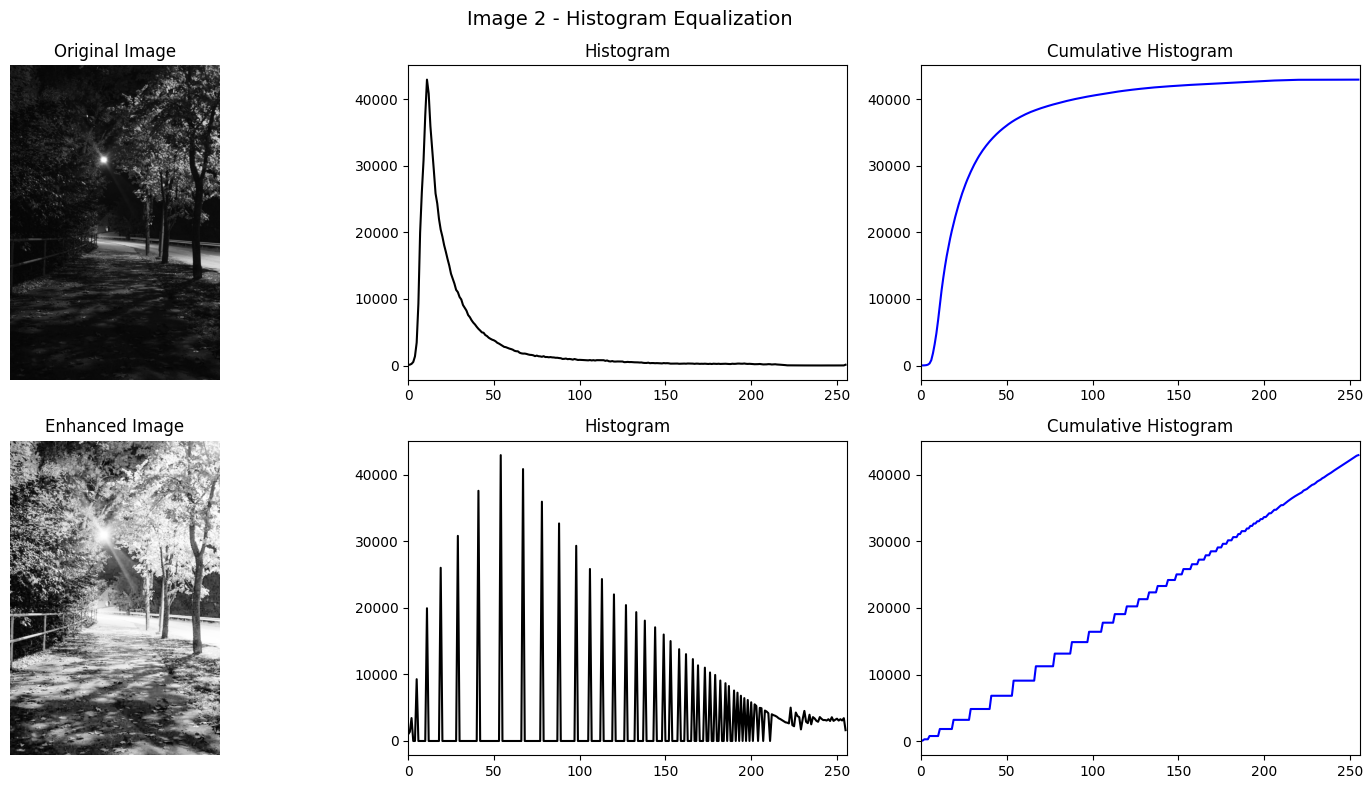

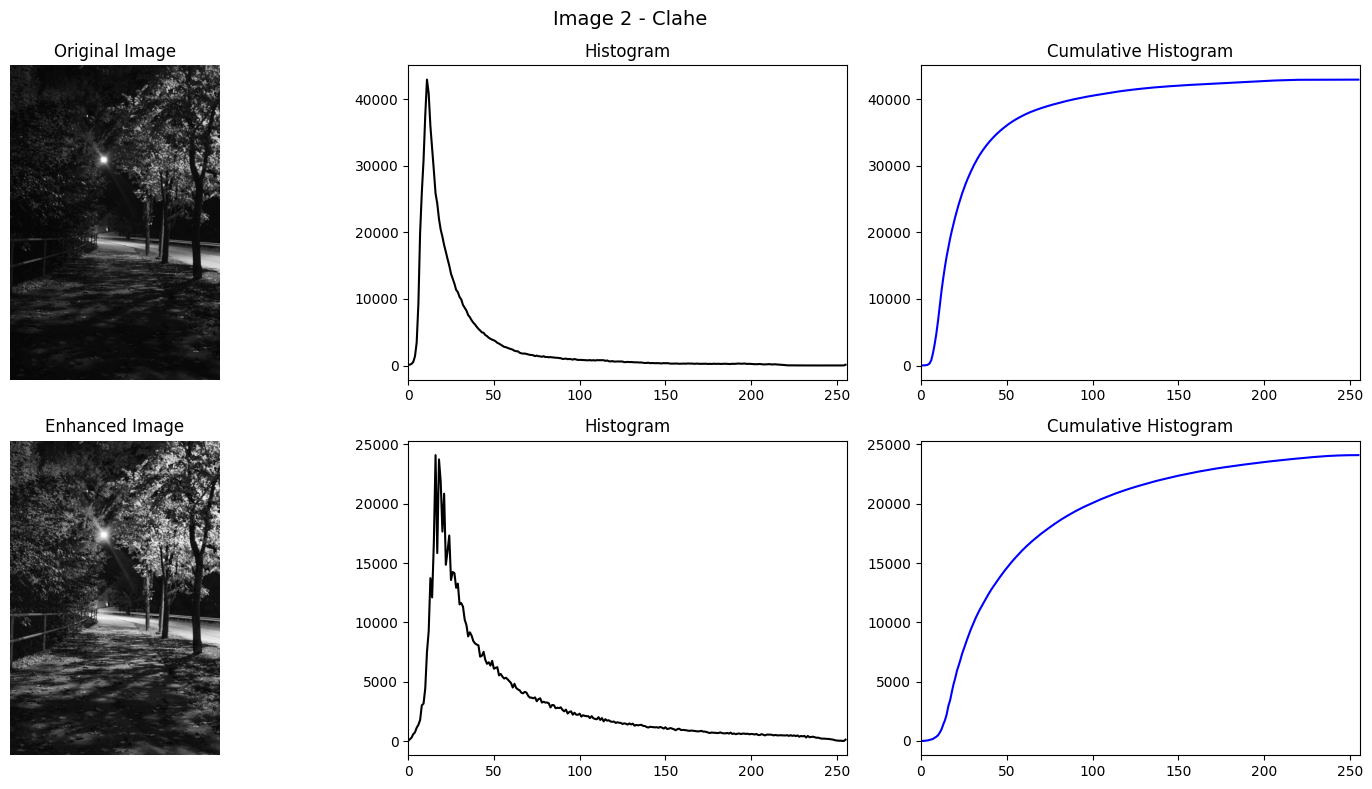

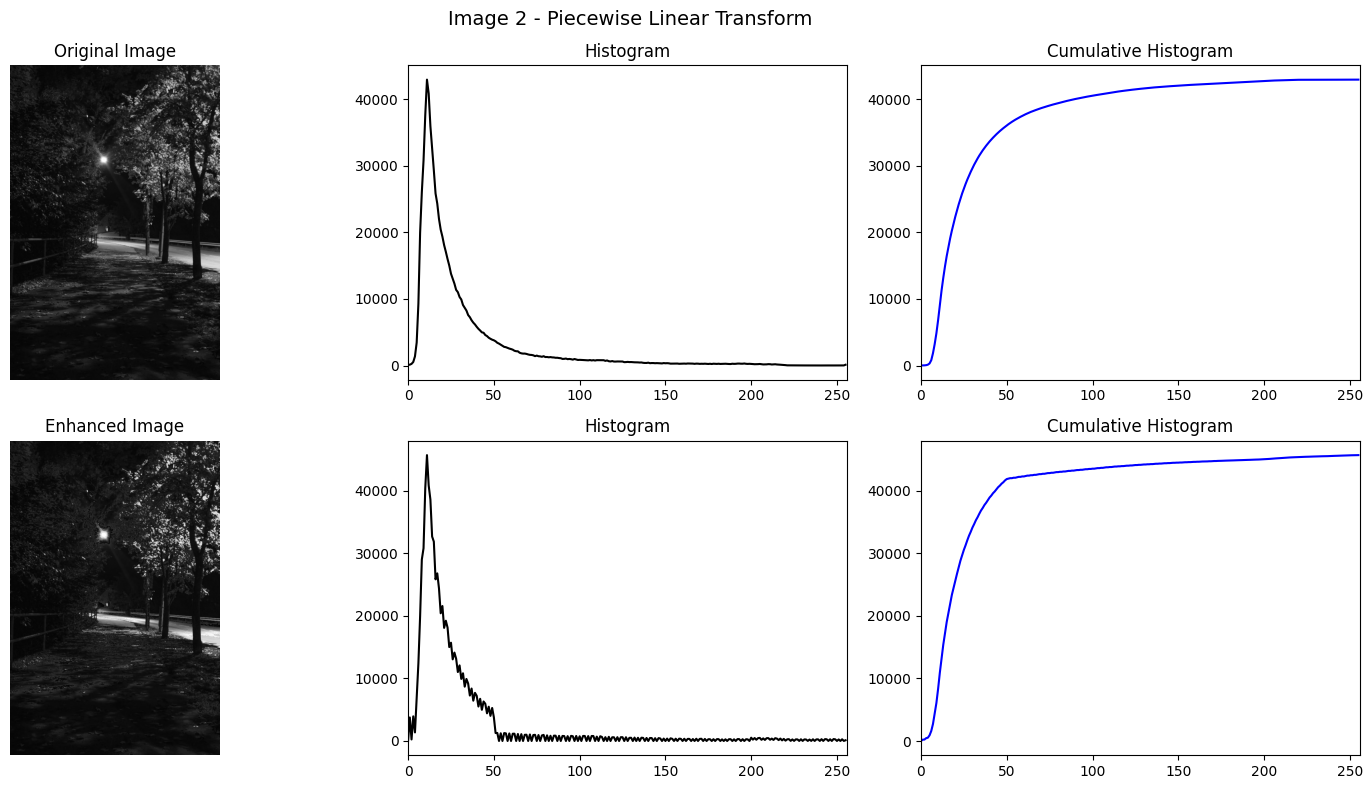

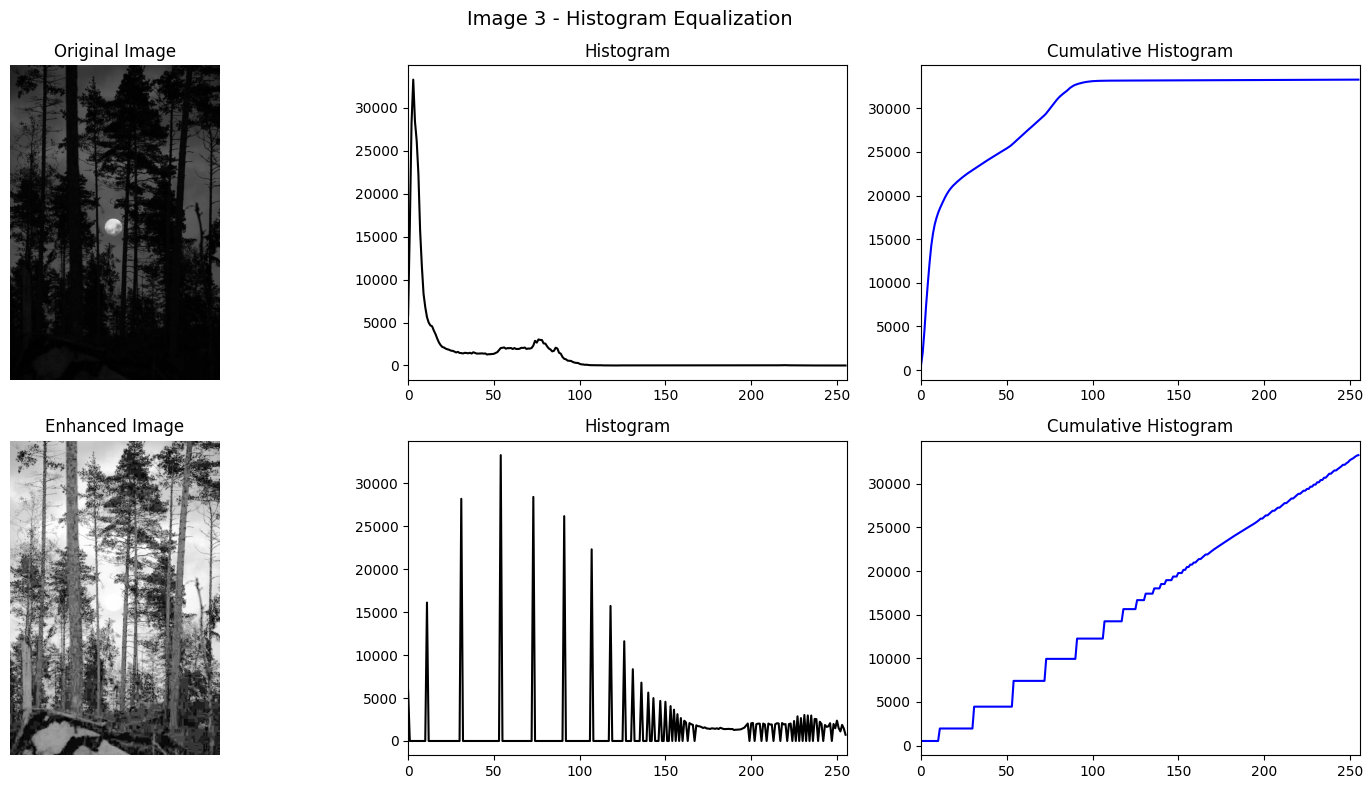

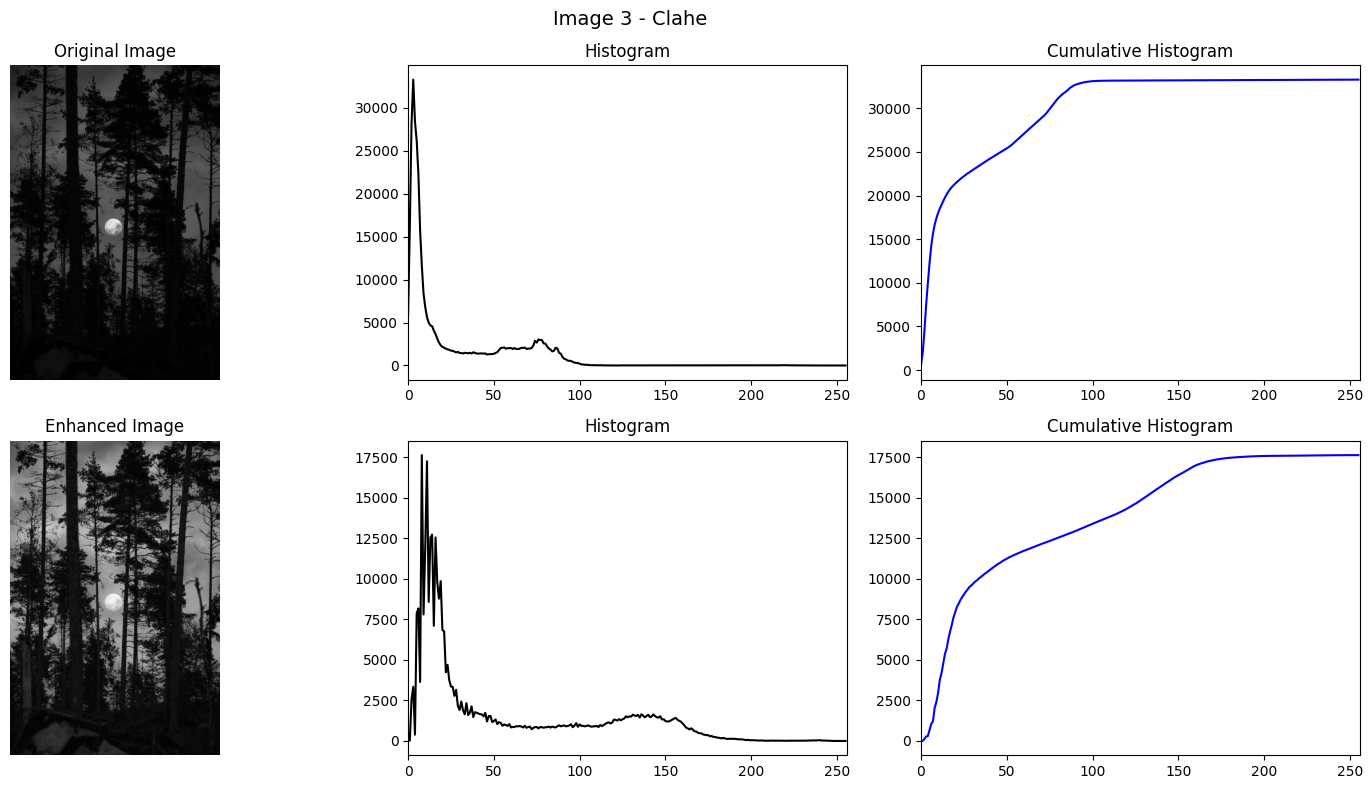

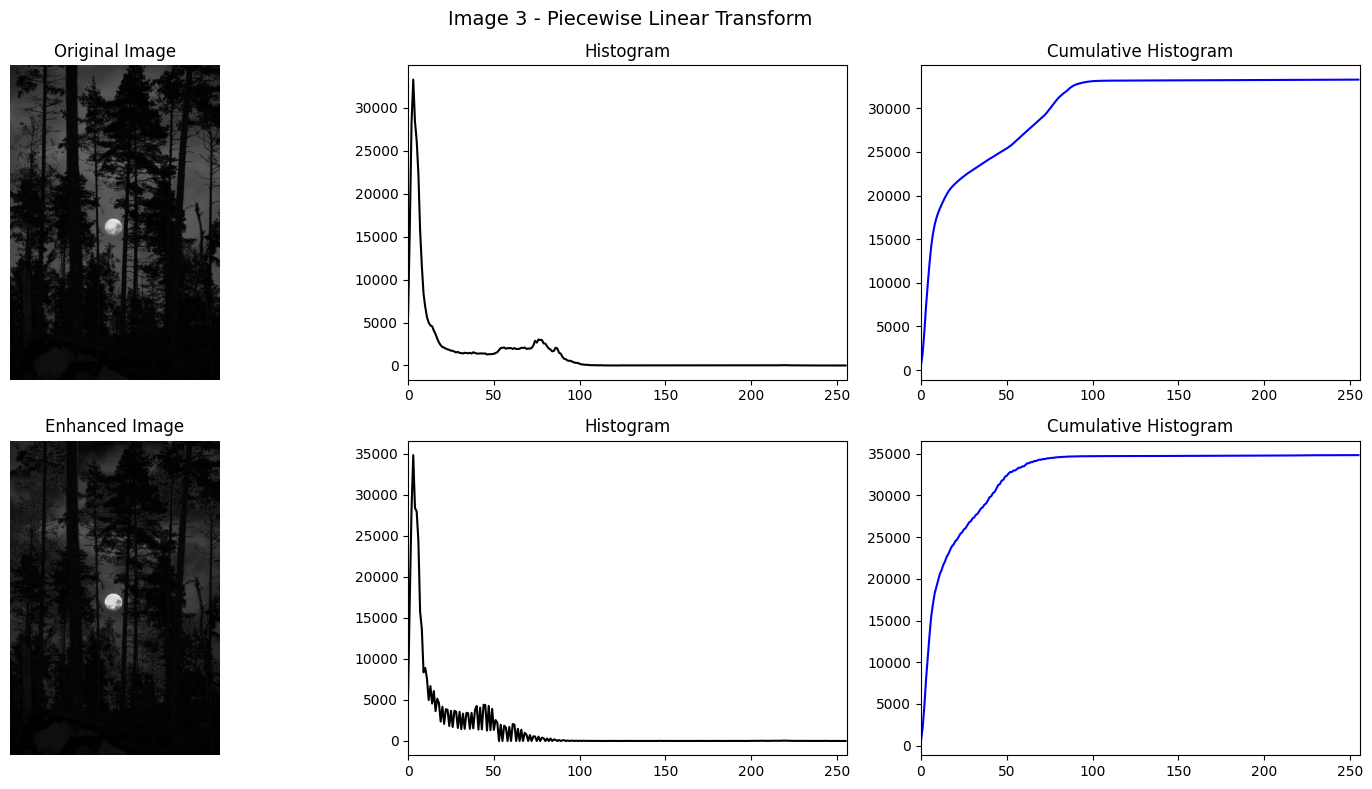


    Analysis Results:
    - Original Contrast (STD): 32.52
    - Enhanced Contrast (STD): 26.57
    - Contrast Improvement: -18.3%
    
    Interpretation:
    The piecewise linear transform enhances mid-tone details while compressing extreme values,
    resulting in a more balanced histogram distribution. This is particularly effective for
    night images where dynamic range is limited.
    

    References:
    1. Lecture Slides: 03_Point_Operations.pptx (Page 13 Example)
    2. Gonzalez & Woods, Digital Image Processing (4th Edition)
    3. OpenCV Documentation: https://docs.opencv.org
    


In [26]:

"""
CSE445 - Image Processing HW2
Histogram Enhancement Techniques
"""

# Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. STEP: Data Loading and Visualization
# =============================================================================
class ImageProcessor:
    def __init__(self, image_paths):
        """
        Initializes the ImageProcessor with given image paths.
        Args:
            image_paths (list): List of paths to the input images.
        """
        self.image_paths = image_paths
        self.images = [self._read_image(path) for path in image_paths]

    def _read_image(self, path):
        """
        Loads an image in grayscale format.
        Args:
            path (str): Path to the image file.
        Returns:
            numpy.ndarray: Grayscale image.
        Raises:
            ValueError: If the image cannot be loaded.
        """
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        return img

    @staticmethod
    def _plot_histograms(img, ax_hist, ax_cdf):
        """
        Plots histogram and cumulative histogram of an image.
        Args:
            img (numpy.ndarray): Input grayscale image.
            ax_hist (matplotlib.axes.Axes): Axis for histogram plot.
            ax_cdf (matplotlib.axes.Axes): Axis for cumulative histogram plot.
        """
        # Calculate histogram using OpenCV for better performance
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()  # Normalize for visualization

        # Plot histogram
        ax_hist.plot(hist, color='black')
        ax_hist.set_title('Histogram')
        ax_hist.set_xlim([0, 256])

        # Plot cumulative histogram
        ax_cdf.plot(cdf_normalized, color='blue')
        ax_cdf.set_title('Cumulative Histogram')
        ax_cdf.set_xlim([0, 256])

# 2. STEP: Histogram Enhancement Methods
# =============================================================================
class EnhancementMethods:
    @staticmethod
    def histogram_equalization(img):
        """
        Applies standard histogram equalization.
        Args:
            img (numpy.ndarray): Input grayscale image.
        Returns:
            numpy.ndarray: Contrast-enhanced image.
        """
        return cv2.equalizeHist(img)

    @staticmethod
    def clahe(img, clip_limit=2.0, grid_size=(8, 8)):
        """
        Applies Contrast Limited Adaptive Histogram Equalization (CLAHE).
        Args:
            img (numpy.ndarray): Input grayscale image.
            clip_limit (float): Threshold for contrast limiting.
            grid_size (tuple): Size of grid for tile-based processing.
        Returns:
            numpy.ndarray: Locally enhanced image.
        """
        clahe = cv2.createCLAHE(
            clipLimit=clip_limit,
            tileGridSize=grid_size
        )
        return clahe.apply(img)

    @staticmethod
    def piecewise_linear_transform(img, thresholds=(50, 200)):
        """
        Applies piecewise linear transform (Page 13 example in lecture notes).
        Args:
            img (numpy.ndarray): Input grayscale image.
            thresholds (tuple): (lower, upper) bounds for dynamic range stretching.
        Returns:
            numpy.ndarray: Transformed image.
        """
        lower, upper = thresholds
        img = img.astype(np.float32)

        # Create masks for three regions
        mask1 = img <= lower      # Dark region: [0, lower]
        mask2 = (img > lower) & (img < upper)  # Mid-tones: (lower, upper)
        mask3 = img >= upper     # Bright region: [upper, 255]

        # Apply transformations
        img[mask2] = ((img[mask2] - lower) / (upper - lower)) * 255  # Linear stretch
        return img.astype(np.uint8)

# 3. STEP: Visual Reporting System
# =============================================================================
class VisualReporter:
    def __init__(self, processor, enhancer):
        """
        Initializes the visual reporter.
        Args:
            processor (ImageProcessor): Loaded image processor.
            enhancer (EnhancementMethods): Enhancement methods handler.
        """
        self.processor = processor
        self.enhancer = enhancer

    def create_comparison_figure(self, img_idx, method_name):
        """
        Generates a comparison figure as per homework requirements.
        Args:
            img_idx (int): Index of the image in the loaded list.
            method_name (str): Name of the enhancement method.
        Returns:
            matplotlib.figure.Figure: Formatted comparison figure.
        """
        img = self.processor.images[img_idx]
        enhanced = getattr(self.enhancer, method_name)(img)

        fig = plt.figure(figsize=(15, 8))
        fig.suptitle(f"Image {img_idx+1} - {method_name.replace('_', ' ').title()}", fontsize=14)

        # Original Image
        ax1 = plt.subplot2grid((2, 3), (0, 0))
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Original Histograms
        ax2 = plt.subplot2grid((2, 3), (0, 1))
        ax3 = plt.subplot2grid((2, 3), (0, 2))
        self.processor._plot_histograms(img, ax2, ax3)

        # Enhanced Image
        ax4 = plt.subplot2grid((2, 3), (1, 0))
        ax4.imshow(enhanced, cmap='gray')
        ax4.set_title('Enhanced Image')
        ax4.axis('off')

        # Enhanced Histograms
        ax5 = plt.subplot2grid((2, 3), (1, 1))
        ax6 = plt.subplot2grid((2, 3), (1, 2))
        self.processor._plot_histograms(enhanced, ax5, ax6)

        plt.tight_layout()
        return fig

# 4. STEP: Main Workflow and Results
# =============================================================================
if __name__ == "__main__":
    # Configure image paths
    image_paths = [
        "night1.jpeg",
        "night2.jpg",
        "night3.jpg"
    ]

    # Initialize system components
    processor = ImageProcessor(image_paths)
    enhancer = EnhancementMethods()
    reporter = VisualReporter(processor, enhancer)

    # STEP 1: Apply All Enhancement Methods
    methods = [
        ('histogram_equalization', 'Histogram Equalization'),
        ('clahe', 'CLAHE'),
        ('piecewise_linear_transform', 'Piecewise Linear Transform')
    ]

    # Generate figures for all images and methods
    for img_idx in range(3):
        for method, title in methods:
            fig = reporter.create_comparison_figure(img_idx, method)
            plt.show()

    # STEP 2: Custom Transformation Analysis
    selected_img = processor.images[0]
    transformed = enhancer.piecewise_linear_transform(selected_img)

    # Quantitative Analysis
    orig_contrast = np.std(selected_img)  # Standard deviation as contrast measure
    enhanced_contrast = np.std(transformed)

    print(f"""
    Analysis Results:
    - Original Contrast (STD): {orig_contrast:.2f}
    - Enhanced Contrast (STD): {enhanced_contrast:.2f}
    - Contrast Improvement: {(enhanced_contrast/orig_contrast-1)*100:.1f}%

    Interpretation:
    The piecewise linear transform enhances mid-tone details while compressing extreme values,
    resulting in a more balanced histogram distribution. This is particularly effective for
    night images where dynamic range is limited.
    """)

    # References
    print("""
    References:
    1. Lecture Slides: 03_Point_Operations.pptx (Page 13 Example)
    2. Gonzalez & Woods, Digital Image Processing (4th Edition)
    3. OpenCV Documentation: https://docs.opencv.org
    """)